**Importing Data**



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:

#!unzip /content/drive/MyDrive/FYP/FYP.zip -d /content/drive/MyDrive/FYP
#!unzip /content/drive/MyDrive/FYP/FYP/Dataset/general/archive.zip -d /content/drive/MyDrive/FYP/FYP/Dataset/general/archive

archive      hatecheck	       labeled_data.csv.zip
archive.zip  labeled_data.csv  sources.txt


In [8]:
!mkdir /content/trainedModels

mkdir: cannot create directory ‘/content/trainedModels’: File exists


# Dependencies

In [74]:
!nvidia-smi

Wed Dec 22 23:58:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [75]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 61 kB 541 kB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 596 kB 46.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [76]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [77]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


In [78]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 4.15.0



In [79]:
!pip install nlpaug

     |████████████████████████████████| 408 kB 5.5 MB/s 
     |████████████████████████████████| 11.3 MB 43.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


### Making the necessary imports

In [80]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [81]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Importing Data

In [140]:
df = pd.read_csv("/content/drive/MyDrive/FYP/FYP/Dataset/overall/dataset (1).csv", index_col=0)

In [141]:
df.head()

,index,class,tweet
0,1,1.0,boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
1,2,1.0,Dawg You ever fuck a bitch and she start to cry? You be confused as shit
2,3,1.0,she look like a tranny
3,4,1.0,The shit you hear about me might be true or it might be faker than the bitch who told it to ya
4,5,1.0,""" The shit just blows me..claim you so faithful and down for somebody but still fucking with hoes! """


In [143]:
df = df.drop(['index'], axis=1)

In [144]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(20)

,class,tweet
49196,0.0,I thought that one ofthe advantages of marryingan older guy...
15208,1.0,bitch i don't fucking know you
37382,0.0,I know all the games I use them myself.
48769,0.0,Cam what are you doing up there?
61528,0.0,The foreign Krustysare all hotter than you.
14225,1.0,if I got hoes.. @ one of my hoes.. if not shutup never say it again
12506,1.0,This bitch just blew my high and I was high off all of these drugs
22905,2.0,Greece need a man like Adolf Hitler and now is the perfect time to start a national political movement to free Your country from the zionist bankers
60198,0.0,- Oh God!- Thank you.
53339,0.0,Let's go let's go MEREDITH


In [72]:
# df.loc[df['class']==0,'class'] = 'hatespeech'
# df.loc[df['class']==1,'class'] = 'non hatespeech'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


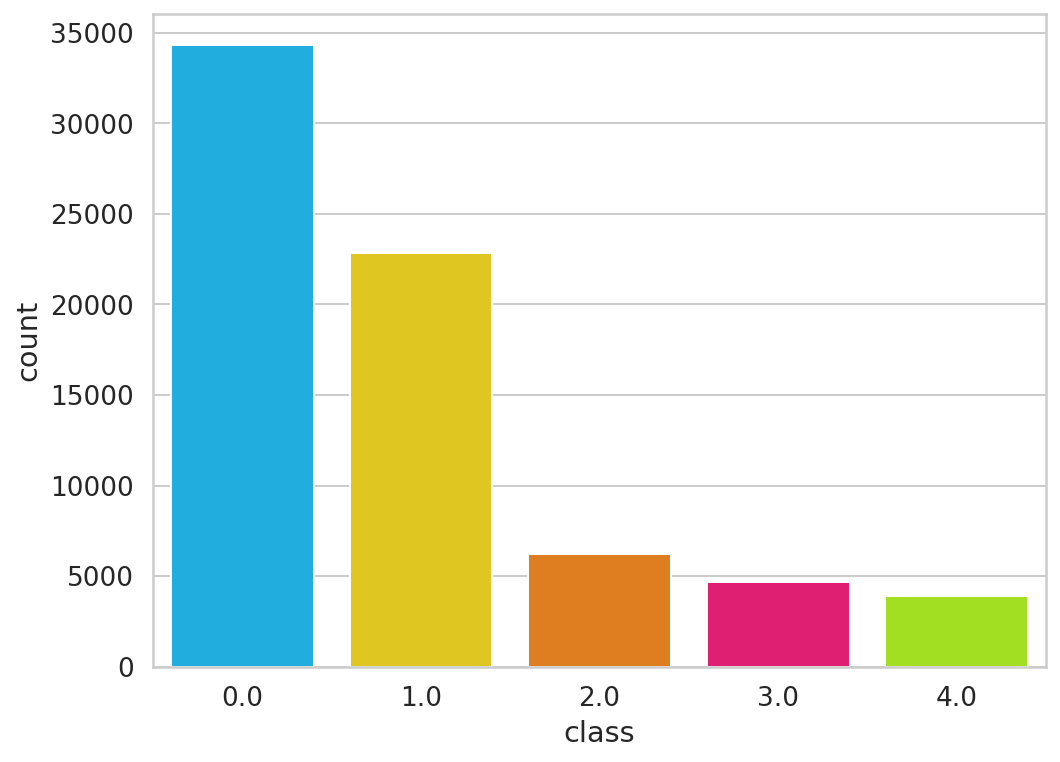

In [145]:
rcParams['figure.figsize'] = 8, 6
sns.countplot(df['class'])
plt.xlabel('class');

In [146]:
class_names = ['non_hatespeech','hatespeech','racism','sexism', 'islamophobia']

### XLNetTokenizer

In [147]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [148]:
type(tokenizer)

transformers.models.xlnet.tokenization_xlnet.XLNetTokenizer

### Checking the distribution of token lengths

In [90]:
token_lens = []

for txt in df['tweet']:
  tokens = tokenizer.encode(txt, max_length=128*2, truncation=True)
  token_lens.append(len(tokens))

In [91]:
print(max(token_lens))

256


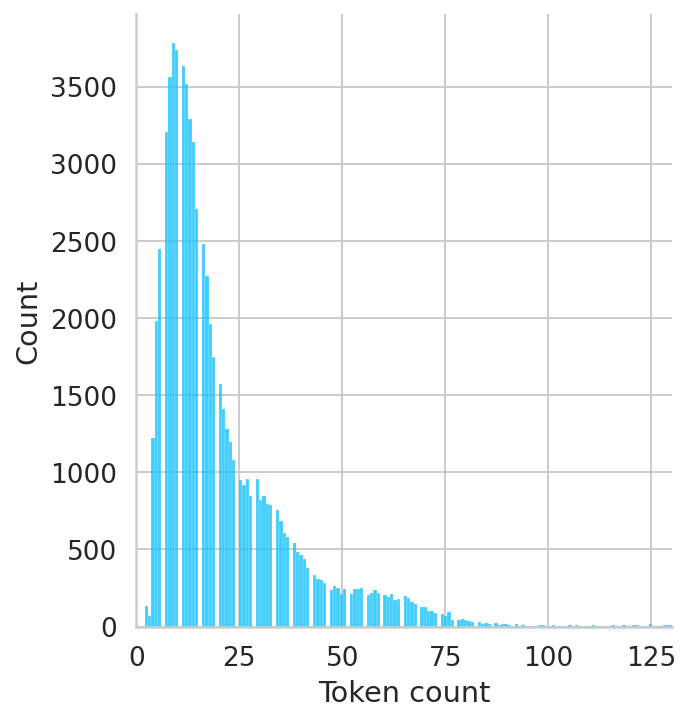

In [92]:
sns.displot(token_lens)
plt.xlim([0, 130]);
plt.xlabel('Token count');

In [93]:
df.head()

,index,class,tweet
4947,5983,1,"""bitches talk shit, you got the right to swerve"" god damnit you are da shittt"
13207,15880,1,Any bitch who need a crowd to fight is clearly easily influenced weak minded most likely will commit suicide
45633,90234,0,As long as it gets us loopy.
56879,101480,0,All my decisions are final.
24689,68066,2,maybe the muzzies should be turned loose on her she would probably enjoy a gang rape


In [94]:
df['class'] = df['class'].astype(int)

In [95]:
# df.loc[:,"class"] = df.loc[:, "class"].apply(to_label)

In [96]:
MAX_LEN = 128

In [97]:
df.head()

,index,class,tweet
4947,5983,1,"""bitches talk shit, you got the right to swerve"" god damnit you are da shittt"
13207,15880,1,Any bitch who need a crowd to fight is clearly easily influenced weak minded most likely will commit suicide
45633,90234,0,As long as it gets us loopy.
56879,101480,0,All my decisions are final.
24689,68066,2,maybe the muzzies should be turned loose on her she would probably enjoy a gang rape


### Custom Dataset class

In [98]:
class Dataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=False,
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'tweet': tweets,
        'input_ids': input_ids,
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [99]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=101)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=101)

In [100]:
df_train.shape, df_val.shape, df_test.shape

((54000, 3), (9000, 3), (9000, 3))

In [101]:
df_val.head()

,index,class,tweet
3118,3711,1,I'm not a bitch. Take it back.
617,728,1,#InMiddleSchool i was fat as hell and was a band faggot. Thank god i played sports after 6th grade and didnt stay in band
61472,106073,0,But that doesn't meanthat you can't have a little dinner.
25943,69320,2,my ignorance proves i know nothing about this nigger comic i am good with that
42543,87144,0,Joey: I'm sorry but every time we fed her she'd drool or dribble or spit up.


### Custom Dataloader

In [102]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Dataset(
    tweets=df.tweet.to_numpy(),
    targets=df.loc[:,'class'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [103]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [104]:
len(df_train)

54000

### Loading the Pre-trained XLNet model for sequence classification from huggingface transformers

In [105]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 5)
model = model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [106]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

### Setting Hyperparameters

In [107]:
EPOCHS = 3

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

### Sanity check with one batch

In [108]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [109]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(BATCH_SIZE,MAX_LEN).shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 128])
torch.Size([8, 128])


In [110]:
input_ids[0]

tensor([[   35,    26,    98,    50,    24, 15683,     9,  3636,    36,   126,
             9,     4,     3,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [111]:
outputs = model(input_ids.reshape(BATCH_SIZE,MAX_LEN), token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput([('loss',
                                       tensor(1.5024, device='cuda:0', grad_fn=<NllLossBackward0>)),
                                      ('logits',
                                       tensor([[ 0.4248,  0.2524,  0.2360, -0.7005, -0.6251],
                                               [ 0.1362, -0.0180,  0.5987, -0.3329, -0.4114],
                                               [ 0.0876, -0.0933,  0.4898, -0.3610, -0.2057],
                                               [ 0.2316,  0.2095,  0.1947, -0.5720, -0.3339],
                                               [ 0.0431,  0.3824,  0.1824, -0.2314, -0.2584],
                                               [ 0.1472,  0.1028,  0.2898, -0.2195, -0.2829],
                                               [ 0.2721, -0.0367,  0.3575, -0.4994, -0.3542],
                                               [ 0.1443,  0.4955,  0.1843, -0.6984, -0.1641]], device='cuda:0',
                                 

In [112]:
type(outputs[0])

torch.Tensor

### Defining the training step function

In [113]:
from tqdm import tqdm
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].reshape(BATCH_SIZE,MAX_LEN).to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

### Defining the evaluation function

In [114]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].reshape(BATCH_SIZE,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

### Fine-tuning the pre-trained model

In [ ]:

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device,
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), '/content/trainedModels/xlnet_model2.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


100%|██████████| 6750/6750 [1:02:30<00:00,  1.80it/s]


Train loss 0.36168348282181517 Train accuracy 0.8887777777777778


100%|██████████| 1125/1125 [03:35<00:00,  5.23it/s]


Val loss 0.3015601224577468 Val accuracy 0.9158888888888889

Epoch 2/3
----------


100%|██████████| 6750/6750 [1:01:39<00:00,  1.82it/s]


Train loss 0.24209188644086976 Train accuracy 0.9290925925925926


100%|██████████| 1125/1125 [03:30<00:00,  5.34it/s]


Val loss 0.25848535900376735 Val accuracy 0.9287777777777778

Epoch 3/3
----------


  1%|          | 34/6750 [00:18<1:01:24,  1.82it/s]


KeyboardInterrupt: ignored

### Evaluation of the fine-tuned model

In [115]:
model.load_state_dict(torch.load('/content/drive/MyDrive/FYP/FYP/trainedModels/xlnet_model2(epoch2).bin'))

<All keys matched successfully>

In [116]:
model = model.to(device)

In [117]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

100%|██████████| 1125/1125 [03:06<00:00,  6.04it/s]

Test Accuracy : 0.9032222222222223
Test Loss : 0.48908587210356363


In [118]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["tweet"]
            input_ids = d["input_ids"].reshape(BATCH_SIZE,MAX_LEN).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [119]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [120]:
print(classification_report(y_test, y_pred, target_names=class_names))

                precision    recall  f1-score   support

    hatespeech       0.99      0.94      0.96      4269
non_hatespeech       0.89      0.99      0.94      2831
        racism       0.79      0.84      0.81       783
        sexism       0.90      0.69      0.78       619
  islamophobia       0.48      0.48      0.48       498

      accuracy                           0.90      9000
     macro avg       0.81      0.79      0.79      9000
  weighted avg       0.91      0.90      0.90      9000



In [ ]:
!mkdir /content/drive/MyDrive/FYP/FYP/trainedModels
!cp /content/trainedModels/xlnet_nodel.bin /content/drive/MyDrive/FYP/FYP/trainedModels/

### Custom prediction function on raw text

In [122]:
def predict_sentiment(tweet):
    
    review_text = tweet

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=False,
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,MAX_LEN).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("non hate:", probs[0])
    print("hate:", probs[1])
    print(f' text: {review_text}')
    print(f'type  : {class_names[prediction]}')

In [136]:
text = "I hate muslims"
predict_sentiment(text)

non hate: 0.00029944669222459197
hate: 0.4977996349334717
 text: I hate muslims
type  : islamophobia


In [ ]:
df_test['tweet'][14188]

'Pisses me of when I see these little liberal faggots wearing Che Guevara shirts. Move ur ass to Cuba. '

In [137]:
for index,row in df_test.iterrows():
  print(row['tweet'])

Streaming output truncated to the last 5000 lines.
It was on “pause” by the Obama administration no less. Yet CDC, NIH, et al soldiered on till they had just the right mix. 1st boogeyman, mutual assured annihilation vis a vi Soviet’s, 2nd boogeyman Muslim terror, 3rd serial killer w/gang Covid. General to particular. Progress..
If only everyone knew the real you...fakest bitch I know
TWO STUDENTS : Yeah!
Hey Krusty ...
I'm just gonna wind upa dried-up old maid
stick by his side and don't give his pussy up . .
also that he a faggot and serial mudshark 
Arabs by bombs from Muslim haters to kill people in Muslim lands. #muslims #arabs #DubaiExpo2020
y don't both of those fat bitches die
so essentially history was all done by white people whilst the brown devils kept trying to genocide us because we were gigantic red headed cannibals well this explains everything even trump 
Dad you gave methe drowsy kind.
#IDontHaveTimeFor Ratchet hoes.
tired of these pussy fucking memes make one it ok to